ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **07Sep21**

# 01. Introduction/Basis Functions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Collocation Points](#colpts)
* [Inner Product and Norm of Scalar, Real-Valued Functions](#inner-product-norm)
* [Fourier Basis Functions](#fourier-basis)
* [Wavelet Basis Functions](#wavelet-basis)
* [Legendre Polynomial Basis Functions](#legendre-basis)
* [Linear Combination of (Non-Linear) Basis Functions](#lincomb)
* [Optimal Combination Coefficients](#optimal-coeff)
* [Best Approximant Function](#approximant)
* [Residual](#fourier-residual)
---

## [Objectives](#toc)<a id="obj"></a>

 + Introductory comments on the course ([hand-written notes in OneNote](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/ElFMPfKQMUNMkNC0zmwTVc0BYyX5Y_bB8MFfE-VxxEtNfA?e=NyfE07)).
 + Function *approximation theory* ([hand-written notes in OneNote](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eg7XSdAYHC9Fpzxuz2aMXMwBMl0tRiBq1Z5eLvvUq5auew?e=yueO0O)) related to the finite element method.
   - Basis functions.
   - Linear combination of (non-linear) basis functions.
   - Function approximation via Galerkin residual minimization (*e.g.* least-squares) on collocation points.

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* (for the most part, integrable, no high-order singularities) target function $f:[a,b]\in\Reals\rightarrow\Reals$ how can we systematically compute an approximant $g:[a,b]\in\Reals\rightarrow\Reals$? Why would anyone care about this? The reason is that the ability to approximate a given $f$ helps building methods to approximate $f$ when it is not explicitly given but sought as the solution of a mathematical problems such as an ODE or PDE. There is also intrinsic value in being able to approximate a function or its values as in signal processing and other data analysis areas.

# shape pts =  12


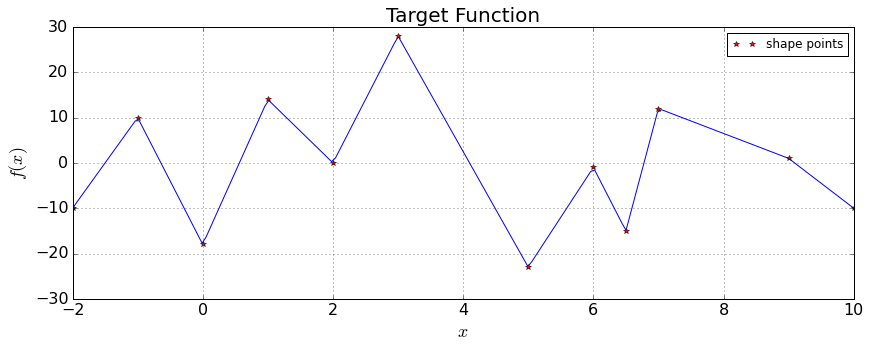

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10), (-1,10), (0,-18), (1,14), (2,0), (3,28), (5,-23), (6, -1), (6.5, -15), (7,12), (9,1), (10,-10)]
print('# shape pts = ', len(shape_pts))

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

**NB: shape points are useful to define functions unambiguously; these points are not part of the theory described here; just a means for function generation.**

## [Collocation Points](#toc)<a id="colpts"></a>

If $g$ is obtainable, how would we compare to $f$? On the whole $\Reals$? This prompts the simple idea of computing $g$ to approximate $f$ on a selected number of points in $\Reals$. While this may be seen as a *discretization* scheme, there is another fundamental choice, namely a basis functions set, which is a part of the greater approximation scheme as described below; this makes the overall method transcend a typical discretization scheme. Hence, let's select a number of *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$. Now we can ask a more definite question. How do we make $g$ and $f$ to be very close when evaluated at the collocation points? Ideally if $m\rightarrow\infty$ then $f\approx g$ to a very good approximation.

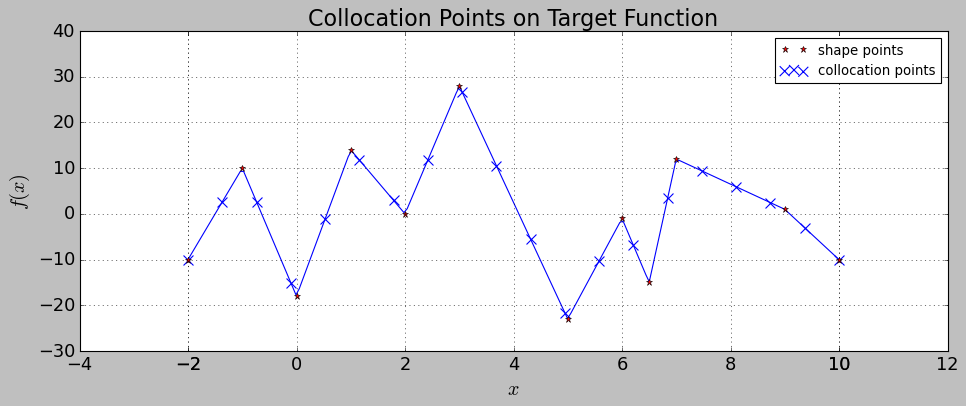

In [2]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 20
assert m >= len(shape_pts)

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function')

## [Inner Product and Norm of Scalar, Real-Valued Functions](#toc)<a id="inner-product-norm"></a>

Given any two scalar, real-valued functions on the line interval, $[a,b]\in\Reals$, for instance,  $f:[a,b]\rightarrow\Reals$, and $g:[a,b]\rightarrow\Reals$, we define the **inner product** using the Lebesgue integral

\begin{equation*}
 (f,g) := \int\limits_a^b \, f(x)\,g(x) \,dx .
\end{equation*}

There exists an *outside* mathematical structure surrounding this inner product definition, that is, an *inner-product space*. That is, a set of functions equipped with additional mathematical structure constitutes a space. An inner-product space has many additional structure elements involving a set of functions, one of the elements is an inner-product. For now we will ignore this inner-product space and worry about the computational usage of some concepts.

A norm can be defined in terms of this inner product:

\begin{equation*}
 \norm{f}_{L_2(a,b)} := \sqrt{(f,f)} = \sqrt{\int\limits_a^b \, f^2(x)\,dx} ,
\end{equation*}

which is called the $L_2$ norm of $f$. Any function with a finite $L_2$ norm is said square integrable in $[a,b]$. We will use norms to compare functions, and inner products to state variational principles.

We say $f$, and $g$ are orthogonal functions on $[a,b]$ if

\begin{equation*}
 (f,g) = 0.
\end{equation*}

**Error based on the underlying function theory.**

Note that $ \norm{f}_{L_2(a,b)} \approx \norm{g}_{L_2(a,b)}$ does not imply $f\approx g$ because the norm is essentially a measure of the total area (positively evaluated) under the graph of the function. Two very different functions may have similar areas (or similar norms).


However,

\begin{equation*}
 \norm{f-g}_{L_2(a,b)} = \sqrt{\int\limits_a^b \, \bigl(f(x) - g(x)\bigr)^2\,dx} .
\end{equation*}

is useful when computing the relative percent error:

\begin{equation*}
 \frac{ \norm{f-g}_{L_2(a,b)} }{ \norm{f}_{L_2(a,b)}} \, 100 .
\end{equation*}

## [Fourier Basis Functions](#toc)<a id="fourier-basis"></a>

The list, $V$, of cosine and sine functions, $\cos:[0,L]\rightarrow\Reals$, $\sin:[0,L]\rightarrow\Reals$,  with a given base wavenumber $\kappa = \frac{2\pi}{L}$:

\begin{equation*}
   V := \{\cos{(k\,\kappa\,\cdot)}, \,\sin{(k\,\kappa\,\cdot)}\, \mid \, k=0,\ldots,N\},
\end{equation*}

is what is called a Fourier basis functions list. This list endowed with an inner product, and the standard real-valued function properties, can be used to build an *inner-product space*. Here the set is actually the list $V$ (since there are no duplicate terms in the list), and the additional structure is what is needed to define an inner product on the $V$ members.

There are two notable properties of this set: 

 1. Linear independence
 2. Orthogonality

That is, if $m$ and $n$ are mode indices:

\begin{align*}
 \bigl(\cos{(m\,\kappa\,\cdot)},\sin{(n\,\kappa\,\cdot)}\bigr) &= \int\limits_0^L \, \cos{(m\,\kappa\,x)}\,\sin{(n\,\kappa\,x)}  \,dx = 0  
 \\
 \bigl(\cos{(m\,\kappa\,\cdot)},\cos{(n\,\kappa\,\cdot)}\bigr) &= \int\limits_0^L \, \cos{(m\,\kappa\,x)}\,\cos{(n\,\kappa\,x)}  \,dx = 
 \begin{cases}
 0 \quad\quad \forall \quad\quad m\ne n  \\
 \frac{L}{2} \quad\quad \forall \quad\quad m = n \ne 0 \\
 L \quad\quad \forall \quad\quad m = n = 0
 \end{cases}
 \\
  \bigl(\sin{(m\,\kappa\,\cdot)},\sin{(n\,\kappa\,\cdot)}\bigr) &= \int\limits_0^L \, \sin{(m\,\kappa\,x)}\,\sin{(n\,\kappa\,x)}  \,dx = 
  \begin{cases}
  0 \quad\quad \forall \quad\quad m\ne n  \\
  \frac{L}{2} \quad\quad \forall \quad\quad m=n\ne0
  \end{cases}
\end{align*}

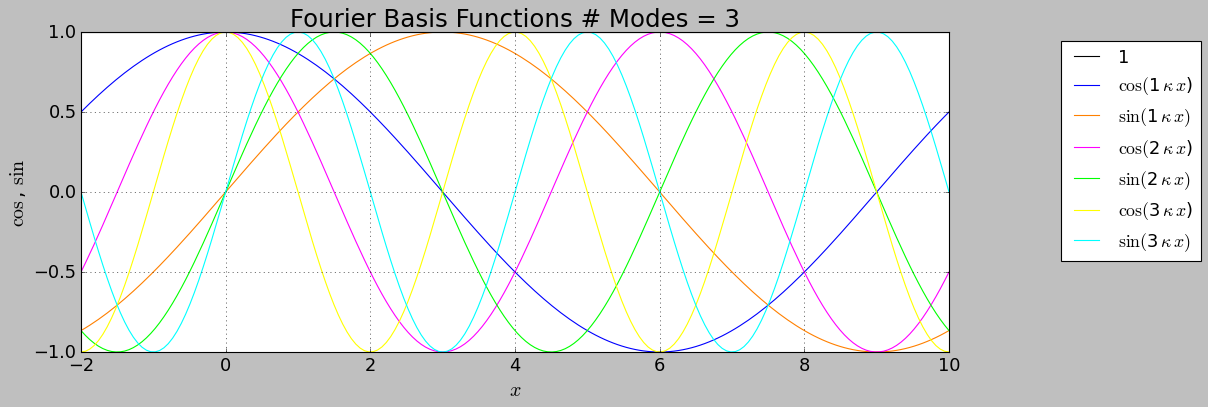

In [3]:
'''Build the basis functions'''

import math

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

N = 3 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
fourier_basis = FourierBasis(kappa, N, x_min, x_max)
fourier_basis.plot()

## [Wavelet (wave packet) Basis Functions](#toc)<a id="wavelet-basis"></a>

The set $V$ (it is actually a list), of chirp wavelet functions, $W_{p,k}:[0,L]\rightarrow\Reals$,  with a given base wavenumber $\kappa = \frac{2\pi}{L}$, standard deviation, $\sigma$, phase angle, $r$:

\begin{equation*}
   V := \{W_{p,k}(k\,\kappa\,\cdot) \, \mid \, p=1,\ldots,P, \, k=0,\ldots,N, \},
\end{equation*}

is what is called a wavelet (wave packet) basis functions set. This set is endowed with an inner product, and the standard real-valued function properties, can be used to build an *inner-product space*. Here the set is actually the list $V$ (since there are no duplicate terms in the list), and the additional structure is what is needed to define an inner product on the $V$ members.

There are various types of wavelets, a **chirp wavelet function** is a Gaussian packet-modulated Fourier mode with a phase shift. It can be implemented in different ways, *e.g.*

\begin{equation*}
W_{p,k}(x) = \begin{cases}
       \sum\limits_p \exp{\biggl(-\frac{\bigl(x-x^{(p)}\bigr)^2}{2\sigma^2}}\biggr) \quad\quad \text{for} \quad\quad   k = 0
       \\
       \exp{\biggl(-\frac{\bigl(x-x^{(p)}\bigr)^2}{2\sigma^2}}\biggr)
       \Bigl(\cos\bigl(k\,\kappa\,x + \frac{r\,x^2}{2}\bigr) + \iota\,\sin\bigl(k\,\kappa\,x + \frac{r\,x^2}{2}\bigr)\Bigr) \quad\quad \forall \quad\quad k > 0,
       \end{cases}
\end{equation*}

for total of $P\,2\,N$ functions.

The Gaussian function is typically scaled by $\sigma\,\sqrt{2\pi}$ to make the area under the curve to be unity as in a 
probability distribution function. Here the maximum value of the basis function for the zero mode $k=0$ is set to one instead of the area under the curve. As such, the wavelets depend on two indices, $p$ and $k$, the first, controls the *bunching* of the wavelet packet, the second, the wavenumber, $k\kappa$, of the mode. This is also know as the Gabor wavelet when there is no phase shift, $r = 0$.

Another implementation used (as in this notebook) is

\begin{equation*}
W_{p,k}(x) = \exp{\biggl(-\frac{\bigl(x-x^{(p)}\bigr)^2}{2\sigma^2}}\biggr)
             \Bigl(\cos\bigl(k\,\kappa\,x + \frac{r\,x^2}{2}\bigr) + \iota\,\sin\bigl(k\,\kappa\,x + \frac{r\,x^2}{2}\bigr)\Bigr)              \quad\quad \forall \quad\quad k \ge 0,
\end{equation*}

for a total of $P\,(2N + 1)$ functions.

A future extension of this basis functions is to allow for variable modes per packet. This allows for further adaptivity of the basis functions.

There is one notable properties of this set: 

 1. Linear independence
 
There is no longer an orthogonality property available.

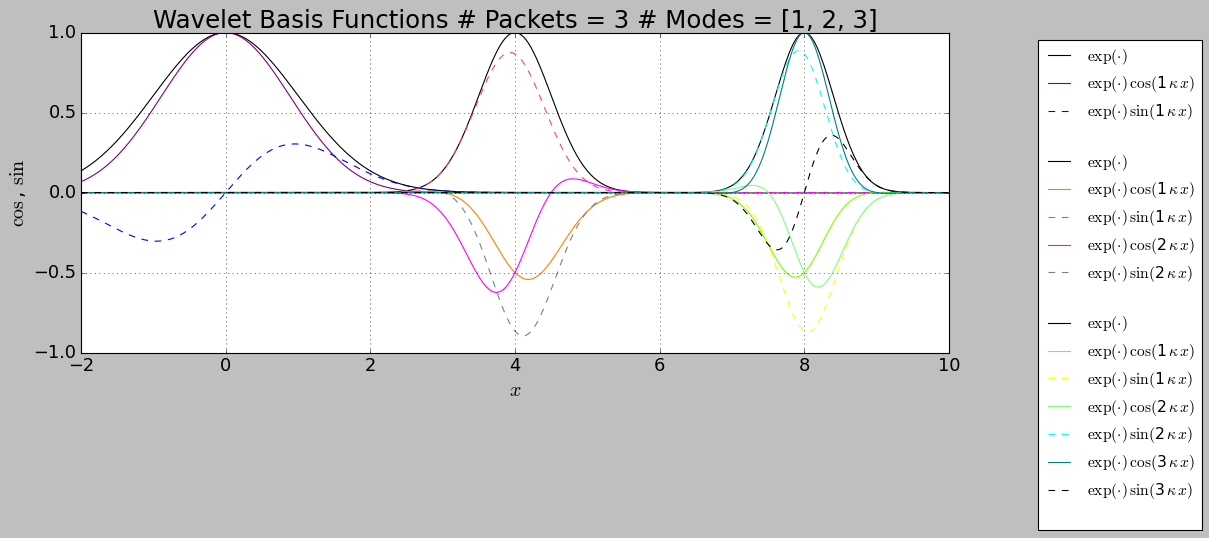

In [10]:
'''Build the basis functions'''

import math

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

bunch_pts = [0, 4, 8] # or a simple integer for equally spaced bunching

#N = 3 # number of modes: pairs of sine/cosine per packet
N = [1,2,3]

try:
    from engy_5310.toolkit import WaveletBasis
except ModuleNotFoundError:
    assert False, 'You need to provide your own basis functions. Bailing out.'

sigma = [1, 0.5, 0.4]
#sigma = 1
phase_shift = 0#.2

wavelet_basis = WaveletBasis(kappa, bunch_pts, N, sigma, phase_shift, x_min, x_max)
wavelet_basis.plot(n_plot_pts=500)

In [ ]:
wavelet_basis.basis_func_list

## [Legendre Polynomial Basis Functions](#toc)<a id="legendre-basis"></a>

A Legendre polynomial, $L_k:[-1,1]\rightarrow\Reals$, basis functions

\begin{equation*}
   V := \{L_k \, \mid \, k=0,\ldots,N\} ,
\end{equation*}

where $N$ is the degree of the basis, is of central importance to finite element methods. This set of basis functions is much less flexible than the Fourier counterpart, unless the function to be approximated is a polynomial function. There are multiple ways to generate Legendre polynomials, here is the most practical:

\begin{align*}
 L_0(\hat{x}) &= 1, \\
 L_1(\hat{x}) &= \hat{x}, \\
 L_k(\hat{x}) &= \frac{2k-1}{k}\,\hat{x}\,L_{k-1}(\hat{x}) - \frac{k-1}{k}\,L_{k-2}(\hat{x}), \quad\quad \forall \quad\quad k=2,\ldots,N .
\end{align*}

where the domain of the polynomial functions can be mapped to by $\hat{x} = 2\,\frac{x - (b+a)/2}{b-a}$, when the interval of approximation of the target function is $[a,b] \in \Reals$.

There are two notable properties of this set: 

 1. Linear independence
 2. Orthogonality
 
 \begin{align*}
 \bigl(L_m,L_n\bigr) &= \int\limits_{-1}^{1} \, L_m(\hat{x})\,L_n(\hat{x})  \,d\hat{x} = 0 \quad\quad \forall \quad\quad m\ne n \\
 \bigl(L_m,L_n\bigr) &= \int\limits_{-1}^{1} \, L_m(\hat{x})\,L_n(\hat{x})  \,d\hat{x} = \frac{2}{2m+1} \quad\quad \forall \quad\quad m = n
\end{align*}

In [ ]:
'''Build the basis functions'''

degree = 6

try:    
    from engy_5310.toolkit import LegendreBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
legendre_basis = LegendreBasis(degree, x_min, x_max)
legendre_basis.plot()

## [Lobatto Polynomial Basis Functions](#toc)<a id="lobatto-basis"></a>

Lobatto polynomials ... coming...


## [Linear Combination of (Non-Linear) Basis Functions](#toc)<a id="lincomb"></a>

A powerful method used to compute an approximant $g$ can be built using the simple structure of a given basis functions set. An approximant **non-linear function** $g$ can be sougth as a **linear combination** of **nonlinear functions**, *e.g* (using Fourier basis functions):

\begin{equation*}
 g(x) := \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\kappa\,x) + \beta_k\,\sin(k\,\kappa\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

Here there are $n=2N+1$ real coefficients $\alpha_k$ and $\beta_k$, and $\kappa$ is the wavenumber. For future reference the vector of coefficients $\cvec \in \Reals^n$, is defined as follows:  $\cvec = \begin{pmatrix}
 \alpha_0 \\ 
 \alpha_1 \\ 
 \beta_1  \\ 
 \vdots \\
 \alpha_N \\ 
 \beta_N \\
\end{pmatrix}$. Furthermore the $g$ function is written with the explicit dependence on the coefficients as parameters:

\begin{equation*}
 g(x; \cvec) = \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\kappa\,x) + \beta_k\,\sin(k\,\kappa\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

How could we compute the *best* values for these coefficients so that $g(\tilde{x}_i,\cvec)$ and $f(\tilde{x}_i)$ are *sufficiently close* for all $\tilde{x}_i$?

Let's define the vector $\tilde{\fvec}\in\Reals^m$ of values $\tilde{f}_i = f(\tilde{x}_i)$ as 
$\tilde{\fvec} = \begin{pmatrix}
 f(\tilde{x}_1) \\ 
 f(\tilde{x}_2) \\ 
 \vdots  \\ 
 f(\tilde{x}_m) \\ 
\end{pmatrix}$ and similarly the vector-valued function of a vector argument, $\tilde{\gvec}:\Reals^n\rightarrow\Reals^m$, that is,
$\tilde{\gvec}(\cvec) = \begin{pmatrix}
 g(\tilde{x}_1,\cvec) \\ 
 g(\tilde{x}_2,\cvec) \\ 
 \vdots  \\ 
 g(\tilde{x}_m,\cvec) \\ 
\end{pmatrix}$, where $\cvec$ is the vector of coefficients. Note that $\tilde{\gvec}$ is a **linear function** of its argument, that is,

\begin{equation*}
 \boxed{\tilde{\gvec}(\cvec) = \tilde{\Amtrx}\,\cvec},
\end{equation*}

where $\tilde{\Amtrx}$ is a $m\times n$ real matrix (called here the basis functions collocation matrix), that is:

$\overset{(m \times n)}{\tilde{\Amtrx}} =  \begin{pmatrix}
1 & \cos(\kappa\,\tilde{x}_1) & \sin(\kappa\,\tilde{x}_1) & \cos(2\kappa\,\tilde{x}_1) & \sin(2\kappa\,\tilde{x}_1) & \ldots & \cos(N\kappa\,\tilde{x}_1) & \sin(N\kappa\,\tilde{x}_1)  \\
1 & \cos(\kappa\,\tilde{x}_2) & \sin(\kappa\,\tilde{x}_2) & \cos(2\kappa\,\tilde{x}_2) & \sin(2\kappa\,\tilde{x}_2) & \ldots & \cos(N\kappa\,\tilde{x}_2) & \sin(N\kappa\,\tilde{x}_2)  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \cos(\kappa\,\tilde{x}_m) & \sin(\kappa\,\tilde{x}_m) & \cos(2\kappa\,\tilde{x}_m) & \sin(2\kappa\,\tilde{x}_m) & \ldots & \cos(N\kappa\,\tilde{x}_m) & \sin(N\kappa\,\tilde{x}_m)  \\
 \end{pmatrix}$.

This important linear relationship is the whole point of using a linear combination of the basis functions as it will be apparent next.

## [Optimal Combination Coefficients](#toc)<a id="optimal-coeff"></a>

It is natural to form the residual function, $\tilde{\rvec}:\Reals^m\rightarrow\Reals^m$ evaluated at $\cvec$, that is, $\tilde{\rvec}(\cvec) := \tilde{\fvec} - \tilde{\gvec}(\cvec)$ and ask the question how to compute $\tilde{\cvec}^*$ so to minimize the magnitude of $\rvec(\tilde{\cvec}^*)$? Arguably the *best* method is to minimize the sum of the squares of the residual vector components,

\begin{equation*}
 \Phi(\tilde{\cvec}^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, \norm{\tilde{\rvec}(\cvec)}^2_2,
\end{equation*}

that is to say, to compute $\tilde{\cvec}^*$ using the least-squares method. To make progress to compute $\cvec^*$, let's rewrite the previous equation as follows

\begin{equation*}
 \Phi(\tilde{\cvec}^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, (\tilde{\Amtrx}\,\cvec-\tilde{\fvec})\cdot(\tilde{\Amtrx}\,\cvec-\tilde{\fvec})
\end{equation*}

We can now impose the optimality condition (directional derivative set to zero in any direction)

\begin{equation*}
 dd_\thetavec \Phi(\tilde{\cvec}^*) = 0 \quad\quad \forall \quad\quad \thetavec\,\in\,\Reals^n .
\end{equation*}

This leads to the least-squares method normal matrix equation

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided in this approximation area by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values (this is not a sufficient condition but a good start). Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient is denoted $\tilde{\cvec}^*$.

Once $\tilde{\cvec}^*$ is computed, it is insightful to compute the residual 2-norm:

\begin{equation*}
 \norm{\tilde{\rvec}(\tilde{\cvec}^*)}_2 = \norm{\tilde{\fvec} - \tilde{\gvec}(\tilde{\cvec}^*)}_2 =  \norm{\tilde{\fvec} - \tilde{\Amtrx}\,\tilde{\cvec}^*}_2,
\end{equation*}

and compare to the corresponding $L^2(a,b)$ norm:

\begin{equation*}
\norm{f-g_\text{best}}_{L^2(a,b)}.
\end{equation*}

## [Best Approximant Function](#toc)<a id="approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\cdot)$ is the Fourier basis functions evaluation matrix on any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec_\text{best}(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

This allows for the computation of the functional norm:

\begin{equation*}
\norm{f-g_\text{best}}_{L^2(a,b)}
\end{equation*}

using quadrature integration.

## [Residual](#toc)<a id="fourier-residual"></a>

**The residual vector also produces information on the goodness of the approximation.**

$\tilde{\rvec}(\xvec) = \tilde{\fvec} - \Amtrx(\xvec)\,\tilde{\cvec}^*$

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.